**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    
- 2. [C++ module](#toc2_)    
- 3. [Algorithms](#toc3_)    
  - 3.1. [Relationship](#toc3_1_)    
  - 3.2. [Diversity](#toc3_2_)    
    - 3.2.1. [Richness Index](#toc3_2_1_)    
    - 3.2.2. [Shannon Diversity Index](#toc3_2_2_)    
    - 3.2.3. [Simpson Diversity Index](#toc3_2_3_)    
    - 3.2.4. [Pielou's Evenness Index](#toc3_2_4_)    
    - 3.2.5. [Bray-Curtis 相似性指数](#toc3_2_5_)    
    - 3.2.6. [Jaccard 相似性指数](#toc3_2_6_)    
- 4. [Diversity Analysis](#toc4_)    
  - 4.1. [Demo datas](#toc4_1_)    
  - 4.2. [analysis](#toc4_2_)    
- 5. [Network analysis](#toc5_)    
- 6. [Difference Analysis](#toc6_)    
  - 6.1. [Pairwise comparison](#toc6_1_)    
    - 6.1.1. [Parameter testing](#toc6_1_1_)    
    - 6.1.2. [Non-parametric testing](#toc6_1_2_)    
    - 6.1.3. [多重检验校正](#toc6_1_3_)    
  - 6.2. [Multiple comparisons](#toc6_2_)    
- 7. [Convert](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Preface](#toc0_)

I plan rewritte all agrithms with PyTorch, and could run on GPU device.

<div style="display:flex;justify-content:center">

```mermaid
graph TD
    python[Python tool] --"PyTorch, Numpy"--> algorithm[Algorithm];
    math[Math background] --"Diversity"--> algorithm[Algorithm];
```

</div>

# 2. <a id='toc2_'></a>[C++ module](#toc0_)

- **pearson.cpp**
```bash
#include <pybind11/pybind11.h>
#include <pybind11/stl.h>

...

namespace py = pybind11;

PYBIND11_MODULE(pearson, m) {
    m.doc() = "Pearson correlation using C++";
    m.def("correlation", &pearson_correlation, "Compute Pearson correlation");
}
```

- **setup.py **
```bash
from setuptools import setup, Extension
import pybind11

ext_modules = [
    Extension(
        name="pearson",
        sources=["pearson.cpp"],
        include_dirs=[pybind11.get_include()],
        language="c++",
    )
]

setup(
    name="pearson",
    version="0.1",
    ext_modules=ext_modules,
)

```

- **setup.cfg**
```bash
[build_ext]
compiler = mingw32
```

- **打包**
```bash
python setup.py build_ext --inplace

```

In [ ]:
from pearson_module import pearson


x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

r = pearson.correlation(x, y)
print(f"Pearson correlation: {r:.4f}")

# 3. <a id='toc3_'></a>[Algorithms](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Relationship](#toc0_)

In [1]:
#@save
import torch 


def pearson(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   Pearson
   Args:
        X: tensor(N, )
        Y: tensor(N, )
    return:
        pearson: tensor
   '''
   X_centered = X - X.mean()
   Y_centered = Y - Y.mean()

   covariance = (X_centered * Y_centered).sum()
   x_std = torch.sqrt((X_centered ** 2).sum())
   y_std = torch.sqrt(torch.pow(Y_centered, 2).sum())
   
   r = covariance / (x_std * y_std)
   return r 



def spearman(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   spearman
   Args:
       X, Y: tensor(N, )
   Return: 
       spearman: tensor
   '''
   d = X - Y
   n = len(X)
   r = 6 * (torch.pow(d, 2).sum()) / ((n-1)*(n**2))
   return r


def sparcc():
   pass 

In [ ]:
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr, spearmanr


# calc pearson
X = torch.arange(10, dtype= torch.float)
Y = torch.arange(10, dtype= torch.float) + 1


plt.figure(figsize= (3, 3))
plt.scatter(torch.arange(10), X, color= 'red')
plt.scatter(torch.arange(10), Y, color= "blue")
plt.title(f"related")
plt.xlabel("X")
plt.ylabel("Y")
print(f"pearson: {pearson(X, Y):.2f}/{pearsonr(X, Y).correlation:.2f}")
print(f"spearman: {spearman(X, Y):.2f}/{spearman(X, Y):.2f}")

## 3.2. <a id='toc3_2_'></a>[Diversity](#toc0_)

### 3.2.1. <a id='toc3_2_1_'></a>[Richness Index](#toc0_)

form: S = 物种总数

解释: 丰富度指数是最简单的多样性指标，仅计算群落中存在的不同物种数量，而不考虑物种的相对丰度。

In [ ]:
#@save 
import torch

def richness_index(species_counts):
    """
    计算丰富度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: int, 物种总数。
    """
    return torch.count_nonzero(species_counts).item()

In [ ]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])  # 第一个群落的物种个体数

# 计算丰富度指数
richness = richness_index(species_counts)
print("Richness Index:", richness)

Richness Index: 4


form: $S_{\text{Chao1}} = S_{\text{obs}} + \frac{n_1 (n_1 - 1)}{2 (n_2 + 1)}$


其中：
- Sobs: 观测到的物种数量
- n1: 只出现一次的物种数量（单例）
- n2 : 出现两次的物种数量（双例）

解释: Chao1 指数利用稀有物种的频率来推测未观测到的物种数量，适合稀疏采样的数据。

In [ ]:
#@save 
def chao1_richness(species_counts):
    """
    计算Chao1丰富度估计指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, Chao1估计值。
    """
    n1 = torch.sum(species_counts == 1)  # 单例物种数量
    n2 = torch.sum(species_counts == 2)  # 双例物种数量
    s_obs = richness_index(species_counts)  # 观测到的物种数量
    if n2 == 0:
        n2 = 1  # 避免除以零
    chao1 = s_obs + (n1 * (n1 - 1)) / (2 * (n2 + 1))
    return chao1.item()

In [ ]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算Chao1丰富度估计指数
chao1 = chao1_richness(species_counts)
print("Chao1 Richness Estimate:", chao1)

Chao1 Richness Estimate: 4.0


### 3.2.2. <a id='toc3_2_2_'></a>[Shannon Diversity Index](#toc0_)

Shannon Diversity Index, H 

香农多样性指数结合了物种丰富度和均匀度： $H=-\sum_{i=1}^Sp_i\ln(p_i)$

- $p_i$ :第 i 个物种的相对丰度

解释: 香农指数衡量的是“不确定性”或信息熵。当所有物种的丰度相等时，不确定性最大；当少数物种占主导地位时，不确定性较小。

In [ ]:
#@save 
def shannon_diversity_index(species_counts):
    """
    计算香农多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 香农指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    p = p[p > 0]  # 去掉零丰度的物种
    h = -torch.sum(p * torch.log(p))  # 香农公式
    return h.item()

In [ ]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算香农多样性指数
shannon = shannon_diversity_index(species_counts)
print("Shannon Diversity Index:", shannon)

Shannon Diversity Index: 1.1355507373809814


### 3.2.3. <a id='toc3_2_3_'></a>[Simpson Diversity Index](#toc0_)

form: $D = \sum_{i=1}^{S} p_i^2$

or: $D' = \frac{1}{D}$

- $p_i$ :第 i 个物种的相对丰度

解释: 辛普森指数衡量从群落中随机抽取两个个体属于同一物种的概率。值越小，表示多样性越高。

In [ ]:
#@save 
def simpson_diversity_index(species_counts):
    """
    计算辛普森多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 辛普森指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    d = torch.sum(p**2)  # 辛普森公式
    return d.item()

In [ ]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算辛普森多样性指数
simpson = simpson_diversity_index(species_counts)
print("Simpson Diversity Index:", simpson)

Simpson Diversity Index: 0.3739612400531769


### 3.2.4. <a id='toc3_2_4_'></a>[Pielou's Evenness Index](#toc0_)

form: $J = \frac{H}{H_{\text{max}}}$

- H: 实际香农指数
- Hmax =ln(S): 当所有物种丰度相等时的最大香农指数
- S: 物种总数

解释: 均匀度指数衡量物种分布的均衡性。值接近 1 表示物种分布非常均匀，值接近 0 表示分布不均。

In [ ]:
#@save 
def pielou_evenness_index(species_counts):
    """
    计算皮卢均匀度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 均匀度指数值。
    """
    h = shannon_diversity_index(species_counts)  # 计算香农指数
    s = richness_index(species_counts)  # 计算物种丰富度
    h_max = torch.log(torch.tensor(s, dtype=torch.float32))  # 理论最大香农指数
    j = h / h_max  # 均匀度公式
    return j.item()

In [ ]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算皮卢均匀度指数
pielou = pielou_evenness_index(species_counts)
print("Pielou's Evenness Index:", pielou)

Pielou's Evenness Index: 0.8191267251968384


### 3.2.5. <a id='toc3_2_5_'></a>[Bray-Curtis 相似性指数](#toc0_)

form: $BC = 1 - \frac{\sum_{i=1}^{S} |x_i - y_i|}{\sum_{i=1}^{S} (x_i + y_i)}$

其中：
- xi ,yi : 分别是两个群落中第 i 个物种的丰度

解释: Bray-Curtis 指数衡量两个群落物种丰度的差异。值越接近 0 表示差异越大，越接近 1 表示相似性越高。

In [ ]:
#@save 
def bray_curtis_similarity(species_counts_a, species_counts_b):
    """
    计算Bray-Curtis相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Bray-Curtis相似性值。
    """
    diff = torch.abs(species_counts_a - species_counts_b)
    total = species_counts_a + species_counts_b
    bc = 1 - torch.sum(diff) / torch.sum(total)
    return bc.item()

In [ ]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Bray-Curtis相似性指数
bray_curtis = bray_curtis_similarity(species_counts_a, species_counts_b)
print("Bray-Curtis Similarity:", bray_curtis)

Bray-Curtis Similarity: 0.8571428656578064


### 3.2.6. <a id='toc3_2_6_'></a>[Jaccard 相似性指数](#toc0_)

form: $J = \frac{|A \cap B|}{|A \cup B|}$

其中：
- A,B: 分别是两个群落的物种集合
- ∣A∩B∣: 两个群落共有的物种数量
- ∣A∪B∣: 两个群落的所有物种数量

解释: Jaccard 指数衡量两个群落共享物种的比例。值越接近 1 表示相似性越高。

In [ ]:
#@save 
def jaccard_similarity(species_counts_a, species_counts_b):
    """
    计算Jaccard相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Jaccard相似性值。
    """
    a = set(torch.nonzero(species_counts_a, as_tuple=True)[0].tolist())
    b = set(torch.nonzero(species_counts_b, as_tuple=True)[0].tolist())
    # print(a, b)
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    jaccard = intersection / union
    return jaccard

In [ ]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Jaccard相似性指数
jaccard = jaccard_similarity(species_counts_a, species_counts_b)
print("Jaccard Similarity:", jaccard)

Jaccard Similarity: 0.75


# 4. <a id='toc4_'></a>[Diversity Analysis](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Demo datas](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
import torch 


# 设置随机种子以保证结果可重复
np.random.seed(42)

# 定义物种数量和样本数量
num_species = 100
num_samples = 10

# 生成物种名称和样本名称
species_names = [f"Species_{i+1}" for i in range(num_species)]
sample_names = [f"Sample_{i+1}" for i in range(num_samples)]

# 随机生成丰度数据（非负整数）
# abundance_data = np.random.randint(0, 100, size=(num_species, num_samples))
abundance_data = torch.randint(0, 100, size=(num_species, num_samples))

# 构建 DataFrame
abundance_table = pd.DataFrame(abundance_data, index=species_names, columns=sample_names)

# 打印生成的丰度表
print("Generated Species Abundance Table:")
abundance_table

Generated Species Abundance Table:


,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10
Species_1,9,10,60,69,38,11,43,93,3,37
Species_2,29,60,66,87,2,42,9,28,62,76
Species_3,92,17,87,36,36,41,30,28,27,48
Species_4,31,58,65,56,51,27,48,65,3,20
Species_5,38,36,8,61,24,46,1,25,54,34
...,...,...,...,...,...,...,...,...,...,...
Species_96,54,87,46,36,57,44,76,73,83,22
Species_97,21,99,18,47,11,79,17,38,82,58
Species_98,51,58,23,32,62,86,41,20,92,26
Species_99,21,50,9,77,79,55,48,38,5,81


In [ ]:
import pandas as pd 


metainfo = pd.DataFrame({
    "Sample_ID": sample_names,
    "Group": [f"ck" for _ in range(5)] + [f"tr" for _ in range(5)]
})

metainfo

,Sample_ID,Group
0,Sample_1,ck
1,Sample_2,ck
2,Sample_3,ck
3,Sample_4,ck
4,Sample_5,ck
5,Sample_6,tr
6,Sample_7,tr
7,Sample_8,tr
8,Sample_9,tr
9,Sample_10,tr


In [ ]:
# 将元信息与丰度表关联
abundance_table_with_group = abundance_table.T.reset_index()
# abundance_table_with_group = abundance_table.T
abundance_table_with_group = abundance_table_with_group.rename(columns={"index": "Sample_ID"})
abundance_table_with_group = abundance_table_with_group.merge(metainfo, on="Sample_ID")

# print("\nAbundance Table with Group Information:")
abundance_table_with_group = abundance_table_with_group.set_index("Sample_ID")
abundance_table_with_group

,Species_1,Species_2,Species_3,Species_4,Species_5,Species_6,Species_7,Species_8,Species_9,Species_10,...,Species_92,Species_93,Species_94,Species_95,Species_96,Species_97,Species_98,Species_99,Species_100,Group
Sample_ID,,,,,,,,,,,,,,,,,,,,,
Sample_1,9,29,92,31,38,87,50,73,85,33,...,81,28,62,76,54,21,51,21,24,ck
Sample_2,10,60,17,58,36,82,38,40,54,26,...,76,65,97,13,87,99,58,50,82,ck
Sample_3,60,66,87,65,8,80,67,99,65,31,...,14,14,46,16,46,18,23,9,88,ck
Sample_4,69,87,36,56,61,40,2,20,6,79,...,15,32,32,85,36,47,32,77,63,ck
Sample_5,38,2,36,51,24,35,67,3,72,24,...,0,74,51,29,57,11,62,79,82,ck
Sample_6,11,42,41,27,46,14,46,54,29,99,...,88,32,71,99,44,79,86,55,48,tr
Sample_7,43,9,30,48,1,36,31,68,37,46,...,10,34,47,25,76,17,41,48,91,tr
Sample_8,93,28,28,65,25,27,59,42,85,51,...,36,93,35,38,73,38,20,38,46,tr
Sample_9,3,62,27,3,54,27,7,33,28,91,...,1,28,49,89,83,82,92,5,4,tr


## 4.2. <a id='toc4_2_'></a>[analysis](#toc0_)

In [ ]:
# 按分组合并数据（求和）
grouped_abundance = abundance_table_with_group.groupby("Group").mean() # .sum()/.mean()/.max()/.min()


print("\nGrouped Abundance Table (mean):")
grouped_abundance


Grouped Abundance Table (mean):


,Species_1,Species_2,Species_3,Species_4,Species_5,Species_6,Species_7,Species_8,Species_9,Species_10,...,Species_91,Species_92,Species_93,Species_94,Species_95,Species_96,Species_97,Species_98,Species_99,Species_100
Group,,,,,,,,,,,,,,,,,,,,,
ck,48.6,34.8,57.0,48.4,39.0,58.8,75.6,31.0,64.8,16.8,...,28.4,26.0,54.6,20.4,34.0,65.8,38.2,41.2,65.8,78.6
tr,88.6,46.4,66.6,32.2,38.4,67.8,25.8,39.6,52.4,52.8,...,26.2,61.2,32.6,57.8,45.8,68.0,33.8,58.8,19.4,84.2


In [ ]:
# 自定义聚合函数
custom_aggregation = abundance_table_with_group.groupby("Group").agg(
    {"Species_1": "sum", "Species_2": "mean", "Species_3": "max", "Species_4": "min"}
)

print("\nCustom Aggregation Results:")
print(custom_aggregation)


Custom Aggregation Results:
       Species_1  Species_2  Species_3  Species_4
Group                                            
ck           243       34.8         79          8
tr           443       46.4         93          3


In [ ]:
grouped_abundance.T

Group,ck,tr
Species_1,48.6,88.6
Species_2,34.8,46.4
Species_3,57.0,66.6
Species_4,48.4,32.2
Species_5,39.0,38.4
...,...,...
Species_96,65.8,68.0
Species_97,38.2,33.8
Species_98,41.2,58.8
Species_99,65.8,19.4


In [ ]:
abundance_table = grouped_abundance.T

In [ ]:
import pandas as pd
import numpy as np


# 计算每个样本的阿尔法多样性
alpha_diversity = []
for sample in abundance_table.columns:
    counts = abundance_table[sample].values
    counts = torch.tensor(counts, dtype= torch.float)
    richness = richness_index(counts)
    shannon = shannon_diversity_index(counts)
    simpson = simpson_diversity_index(counts)
    pielou = pielou_evenness_index(counts)
    chao1 = chao1_richness(counts)
    alpha_diversity.append({
        "Sample": sample,
        "Richness": richness,
        "Shannon": shannon,
        "Simpson": simpson,
        "Pielou": pielou,
        "Chao1": chao1
    })


alpha_df = pd.DataFrame(alpha_diversity)
print("\nAlpha Diversity Results:")
alpha_df


Alpha Diversity Results:


,Sample,Richness,Shannon,Simpson,Pielou,Chao1
0,ck,100,4.555670,0.010948,0.989251,100.0
1,tr,100,4.552913,0.011029,0.988652,100.0


In [ ]:
# 计算贝塔多样性（两两样本之间的相似性）
sample_names = abundance_table.columns

beta_diversity = []
for i, sample_a in enumerate(sample_names):
    for j, sample_b in enumerate(sample_names):
        if i < j:
            # counts_a = abundance_table[sample_a].values
            # counts_b = abundance_table[sample_b].values
            counts_a, counts_b = [torch.tensor(abundance_table[sample_col].values, dtype=torch.float) for sample_col in [sample_a, sample_b]]
            bray_curtis = bray_curtis_similarity(counts_a, counts_b)
            jaccard = jaccard_similarity(counts_a, counts_b)
            beta_diversity.append({
                "Pair": f"{sample_a}-{sample_b}",
                "Bray-Curtis": bray_curtis,
                "Jaccard": jaccard
            })

beta_df = pd.DataFrame(beta_diversity)

print("\nBeta Diversity Results:")
beta_df


Beta Diversity Results:


,Pair,Bray-Curtis,Jaccard
0,ck-tr,0.835584,1.0


# 5. <a id='toc5_'></a>[Network analysis](#toc0_)

In [ ]:
abundance_table
# abundance_table_with_group

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10
Species_1,9,10,60,69,38,11,43,93,3,37
Species_2,29,60,66,87,2,42,9,28,62,76
Species_3,92,17,87,36,36,41,30,28,27,48
Species_4,31,58,65,56,51,27,48,65,3,20
Species_5,38,36,8,61,24,46,1,25,54,34
...,...,...,...,...,...,...,...,...,...,...
Species_96,54,87,46,36,57,44,76,73,83,22
Species_97,21,99,18,47,11,79,17,38,82,58
Species_98,51,58,23,32,62,86,41,20,92,26
Species_99,21,50,9,77,79,55,48,38,5,81


In [ ]:
feature_table = abundance_table

In [ ]:
# 过滤低丰度物种（例如在少于 50% 的样本中出现且总丰度小于 10 的物种）
min_samples = int(len(feature_table.columns) * 0.5)  # 至少出现在一半的样本中
min_abundance = 10  # 总丰度至少为 10

filtered_table = feature_table[
    (feature_table > 0).sum(axis=1) >= min_samples
]
filtered_table = filtered_table[filtered_table.sum(axis=1) >= min_abundance]

print("\nFiltered Feature Table:")
filtered_table


Filtered Feature Table:


,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10
Species_1,9,10,60,69,38,11,43,93,3,37
Species_2,29,60,66,87,2,42,9,28,62,76
Species_3,92,17,87,36,36,41,30,28,27,48
Species_4,31,58,65,56,51,27,48,65,3,20
Species_5,38,36,8,61,24,46,1,25,54,34
...,...,...,...,...,...,...,...,...,...,...
Species_96,54,87,46,36,57,44,76,73,83,22
Species_97,21,99,18,47,11,79,17,38,82,58
Species_98,51,58,23,32,62,86,41,20,92,26
Species_99,21,50,9,77,79,55,48,38,5,81


常用的方法包括相对丰度标准化（每列除以总丰度）或对数转换。

In [ ]:
# 计算相对丰度
relative_abundance = filtered_table.div(filtered_table.sum(axis=0), axis=1)

# 对数转换（加 1 避免除零错误）
log_transformed = relative_abundance.applymap(lambda x: np.log(x + 1))

print("\nLog-transformed Relative Abundance Table:")
log_transformed


Log-transformed Relative Abundance Table:


C:\Users\zhao\AppData\Local\Temp\ipykernel_4832\2930816055.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed = relative_abundance.applymap(lambda x: np.log(x + 1))


,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10
Species_1,0.001903,0.001791,0.011597,0.014185,0.007660,0.002351,0.007795,0.017849,0.000618,0.008048
Species_2,0.006118,0.010699,0.012749,0.017852,0.000405,0.008948,0.001637,0.005408,0.012695,0.016461
Species_3,0.019280,0.003043,0.016771,0.007426,0.007258,0.008736,0.005445,0.005408,0.005548,0.010428
Species_4,0.006538,0.010344,0.012557,0.011528,0.010267,0.005761,0.008697,0.012509,0.000618,0.004358
Species_5,0.008008,0.006433,0.001554,0.012550,0.004845,0.009796,0.000182,0.004830,0.011066,0.007398
...,...,...,...,...,...,...,...,...,...,...
Species_96,0.011361,0.015477,0.008903,0.007426,0.011468,0.009372,0.013736,0.014037,0.016958,0.004793
Species_97,0.004434,0.017593,0.003493,0.009684,0.002223,0.016764,0.003089,0.007332,0.016756,0.012587
Species_98,0.010734,0.010344,0.004461,0.006603,0.012467,0.018236,0.007434,0.003865,0.018780,0.005662
Species_99,0.004434,0.008924,0.001748,0.015816,0.015859,0.011701,0.008697,0.007332,0.001030,0.017535


In [ ]:
from scipy.stats import spearmanr

# 计算斯皮尔曼相关矩阵
correlation_matrix, _ = spearmanr(log_transformed.T)

# 转换为 DataFrame
correlation_df = pd.DataFrame(correlation_matrix, index=log_transformed.index, columns=log_transformed.index)

print("\nSpearman Correlation Matrix:")
correlation_df


Spearman Correlation Matrix:


,Species_1,Species_2,Species_3,Species_4,Species_5,Species_6,Species_7,Species_8,Species_9,Species_10,...,Species_91,Species_92,Species_93,Species_94,Species_95,Species_96,Species_97,Species_98,Species_99,Species_100
Species_1,1.000000,0.151515,0.078788,0.636364,-0.321212,-0.018182,0.248485,0.175758,0.175758,-0.030303,...,-0.260606,-0.103030,0.284848,-0.575758,-0.151515,-0.515152,-0.393939,-0.854545,0.248485,0.321212
Species_2,0.151515,1.000000,0.333333,-0.018182,0.527273,0.357576,-0.296970,0.187879,-0.248485,-0.006061,...,-0.078788,0.187879,-0.163636,0.054545,0.236364,-0.503030,0.503030,-0.236364,0.054545,-0.078788
Species_3,0.078788,0.333333,1.000000,-0.163636,0.236364,0.539394,0.345455,0.551515,0.296970,-0.066667,...,-0.187879,0.260606,-0.321212,0.212121,0.333333,-0.745455,-0.212121,-0.006061,0.006061,-0.030303
Species_4,0.636364,-0.018182,-0.163636,1.000000,-0.466667,0.078788,0.224242,-0.018182,0.018182,-0.151515,...,-0.551515,-0.115152,-0.030303,-0.551515,-0.587879,-0.078788,-0.345455,-0.672727,-0.090909,0.563636
Species_5,-0.321212,0.527273,0.236364,-0.466667,1.000000,-0.030303,-0.515152,-0.381818,-0.418182,0.442424,...,0.151515,0.284848,-0.066667,0.139394,0.806061,-0.163636,0.587879,0.490909,0.127273,-0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Species_96,-0.515152,-0.503030,-0.745455,-0.078788,-0.163636,-0.442424,-0.272727,-0.418182,-0.200000,0.187879,...,0.369697,-0.260606,-0.115152,-0.090909,-0.187879,1.000000,0.139394,0.369697,-0.515152,-0.272727
Species_97,-0.393939,0.503030,-0.212121,-0.345455,0.587879,-0.163636,-0.454545,-0.090909,-0.296970,0.200000,...,0.006061,0.575758,0.163636,0.454545,0.345455,0.139394,1.000000,0.248485,0.042424,-0.478788
Species_98,-0.854545,-0.236364,-0.006061,-0.672727,0.490909,-0.272727,-0.284848,-0.430303,-0.393939,0.345455,...,0.163636,-0.042424,-0.248485,0.357576,0.466667,0.369697,0.248485,1.000000,-0.066667,-0.321212
Species_99,0.248485,0.054545,0.006061,-0.090909,0.127273,0.078788,0.187879,-0.236364,0.151515,-0.357576,...,-0.272727,0.127273,0.757576,0.321212,0.030303,-0.515152,0.042424,-0.066667,1.000000,0.309091


只保留相关性高于某个阈值的边（例如 0.7）。

In [ ]:
threshold = 0.7

# 提取显著相关的边
edges = []
for i in range(len(correlation_df)):
    for j in range(i + 1, len(correlation_df)):
        if abs(correlation_df.iloc[i, j]) >= threshold:
            edges.append((correlation_df.index[i], correlation_df.columns[j], correlation_df.iloc[i, j]))

print("\nSignificant Edges:")
for edge in edges:
    print(edge)


Significant Edges:
('Species_1', 'Species_98', np.float64(-0.8545454545454544))
('Species_2', 'Species_64', np.float64(-0.7818181818181817))
('Species_2', 'Species_79', np.float64(0.8424242424242423))
('Species_3', 'Species_73', np.float64(-0.7818181818181817))
('Species_3', 'Species_96', np.float64(-0.7454545454545454))
('Species_4', 'Species_12', np.float64(0.7818181818181817))
('Species_4', 'Species_14', np.float64(0.7818181818181817))
('Species_4', 'Species_88', np.float64(0.7454545454545454))
('Species_5', 'Species_23', np.float64(0.8787878787878788))
('Species_5', 'Species_95', np.float64(0.8060606060606059))
('Species_6', 'Species_10', np.float64(-0.7212121212121211))
('Species_6', 'Species_17', np.float64(0.7333333333333332))
('Species_6', 'Species_75', np.float64(-0.7818181818181817))
('Species_6', 'Species_76', np.float64(0.9515151515151514))
('Species_7', 'Species_9', np.float64(0.7696969696969697))
('Species_8', 'Species_22', np.float64(0.7454545454545454))
('Species_9', '

In [ ]:
from igraph import Graph

# 创建无向图
g = Graph()

# 添加节点
g.add_vertices(log_transformed.index)

# 添加边和权重
edge_list = [(log_transformed.index.get_loc(u), log_transformed.index.get_loc(v)) for u, v, w in edges]
weights = [abs(w) for u, v, w in edges]
g.add_edges(edge_list)
g.es["weight"] = weights

print(f"\nNumber of Nodes: {g.vcount()}")
print(f"Number of Edges: {g.ecount()}")


Number of Nodes: 100
Number of Edges: 119


计算节点的度中心性和介数中心性。

In [ ]:
# 计算度中心性
degree_centrality = g.degree()

# 计算介数中心性
betweenness_centrality = g.betweenness(weights= "weight")

print("\nDegree Centrality:")
print(degree_centrality)
print("\nBetweenness Centrality:")
print(betweenness_centrality)


Degree Centrality:
[1, 2, 2, 3, 2, 4, 1, 1, 3, 6, 3, 2, 4, 4, 2, 2, 1, 1, 3, 3, 4, 2, 4, 1, 1, 4, 2, 3, 0, 2, 0, 1, 2, 2, 4, 2, 3, 3, 3, 1, 2, 3, 2, 2, 3, 4, 2, 1, 0, 2, 1, 1, 0, 6, 2, 4, 3, 0, 7, 2, 1, 4, 2, 1, 1, 1, 0, 4, 1, 2, 2, 1, 4, 0, 5, 4, 4, 1, 5, 5, 3, 6, 1, 2, 2, 2, 0, 2, 5, 1, 0, 3, 3, 3, 5, 1, 3, 4, 1, 2]

Betweenness Centrality:
[0.0, 83.0, 83.0, 290.33333333333337, 0.0, 181.0, 0.0, 0.0, 83.0, 426.0, 198.0, 254.33333333333334, 655.6666666666667, 138.0, 83.0, 0.0, 0.0, 0.0, 368.0, 401.0, 160.0, 83.0, 974.0, 0.0, 0.0, 529.0, 83.0, 426.0, 0.0, 0.0, 0.0, 0.0, 83.0, 83.0, 403.3333333333333, 165.0, 588.0, 160.0, 225.0, 0.0, 468.0, 110.0, 83.0, 23.0, 0.0, 166.0, 83.0, 0.0, 0.0, 164.0, 0.0, 0.0, 0.0, 901.6666666666667, 0.0, 657.6666666666667, 438.3333333333333, 0.0, 857.6666666666667, 0.0, 0.0, 297.83333333333337, 243.0, 0.0, 0.0, 0.0, 0.0, 83.0, 0.0, 0.0, 117.0, 0.0, 352.83333333333337, 0.0, 235.0, 2.0, 333.0, 0.0, 265.0, 373.0, 0.0, 935.0, 0.0, 2.0, 164.0, 2.0, 0.0, 155.333333

检测网络中的模块（社区）结构。

In [ ]:
# 检测模块
communities = g.community_multilevel(weights="weight")

print("\nCommunities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {[log_transformed.index[node] for node in community]}")


Communities:
Community 1: ['Species_1', 'Species_6', 'Species_7', 'Species_9', 'Species_10', 'Species_17', 'Species_27', 'Species_45', 'Species_59', 'Species_60', 'Species_66', 'Species_70', 'Species_75', 'Species_76', 'Species_82', 'Species_89', 'Species_98']
Community 2: ['Species_2', 'Species_11', 'Species_19', 'Species_25', 'Species_30', 'Species_43', 'Species_51', 'Species_64', 'Species_77', 'Species_79', 'Species_81', 'Species_94']
Community 3: ['Species_3', 'Species_18', 'Species_32', 'Species_38', 'Species_54', 'Species_56', 'Species_62', 'Species_68', 'Species_73', 'Species_83', 'Species_92', 'Species_93', 'Species_96', 'Species_99']
Community 4: ['Species_4', 'Species_12', 'Species_35', 'Species_57', 'Species_69', 'Species_71', 'Species_88']
Community 5: ['Species_5', 'Species_15', 'Species_23', 'Species_52', 'Species_95', 'Species_100']
Community 6: ['Species_8', 'Species_13', 'Species_16', 'Species_22', 'Species_26', 'Species_28', 'Species_33', 'Species_36', 'Species_39', 

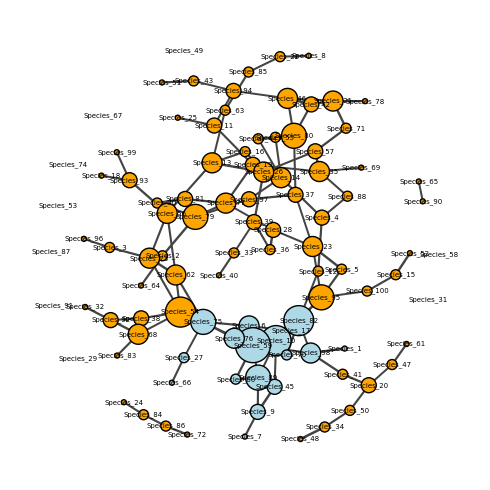

In [ ]:
from igraph import plot
import matplotlib.pyplot as plt 



# 设置节点大小和颜色
node_size = [deg * 5 for deg in degree_centrality]
node_color = ["lightblue" if c == 0 else "orange" for c in communities.membership]

# 绘制网络图
fig, ax = plt.subplots(figsize= (5, 5))
plot(
    g,
    vertex_size=node_size,
    vertex_color=node_color,
    vertex_label=g.vs["name"],
    vertex_label_size = 5,
    edge_width=[abs(w) * 2 for w in g.es["weight"]],
    layout=g.layout("fr"),  # 使用 Fruchterman-Reingold 布局
    bbox=(800, 800),
    margin=50,
    target= ax
)
plt.tight_layout()

# 6. <a id='toc6_'></a>[Difference Analysis](#toc0_)

## 6.1. <a id='toc6_1_'></a>[Pairwise comparison](#toc0_)

### 6.1.1. <a id='toc6_1_1_'></a>[Parameter testing](#toc0_)

- t 检验:
  - 适用于两组样本的比较。
  - 假设数据服从正态分布且方差齐性。
  - 使用 scipy.stats.ttest_ind 实现。

In [ ]:
from scipy.stats import ttest_ind


# Extract the Sample_ID according to metainfo group information.
ck = feature_table.loc[:, metainfo[metainfo['Group'] == "ck"]["Sample_ID"]]
tr = feature_table.loc[:, metainfo[metainfo['Group'] == "tr"]["Sample_ID"]]

In [ ]:

# Perform t-test per specie between ck and tr.
results = []
for specie in feature_table.index:
    t_stat, t_pvalue = ttest_ind(ck.loc[specie], tr.loc[specie])
    results.append({
        "Species": specie,
        "T-statistic": t_stat, 
        "P-value": t_pvalue
    })

results_df = pd.DataFrame(results)
results_df

,Species,T-statistic,P-value
0,Species_1,-0.009957,0.992300
1,Species_2,0.282765,0.784535
2,Species_3,1.202070,0.263708
3,Species_4,1.596083,0.149137
4,Species_5,0.110383,0.914824
...,...,...,...
95,Species_96,-0.250848,0.808254
96,Species_97,-0.767644,0.464750
97,Species_98,-0.461272,0.656886
98,Species_99,0.095494,0.926271


### 6.1.2. <a id='toc6_1_2_'></a>[Non-parametric testing](#toc0_)

- Wilcoxon 秩和检验
  - 非参数检验，不要求数据正态分布。
  - 适用于两组样本的比较。
  - 使用 scipy.stats.ranksums 或 mannwhitneyu 实现。

In [ ]:
from scipy.stats import ranksums


wilcoxon_results = []
for specie in feature_table.index:
    stat, p_value = ranksums(ck.loc[specie], tr.loc[specie])
    wilcoxon_results.append({
        "Species": specie,
        "Statistic": stat, 
        "P-value": p_value
    })

wilcoxon_results_df = pd.DataFrame(wilcoxon_results)
wilcoxon_results_df

,Species,Statistic,P-value
0,Species_1,0.104447,0.916815
1,Species_2,0.313340,0.754023
2,Species_3,0.731126,0.464702
3,Species_4,1.462252,0.143672
4,Species_5,0.104447,0.916815
...,...,...,...
95,Species_96,-0.104447,0.916815
96,Species_97,-0.731126,0.464702
97,Species_98,-0.104447,0.916815
98,Species_99,0.104447,0.916815


### 6.1.3. <a id='toc6_1_3_'></a>[多重检验校正](#toc0_)

使用 Benjamini-Hochberg 方法（FDR 校正）控制假阳性率。

In [ ]:
from statsmodels.stats.multitest import multipletests


# FDR for t-test.
reject, pvals_corrected, _, _ = multipletests(results_df['P-value'], alpha= 0.05, method= "fdr_bh")
results_df["Adjusted P-value"] = pvals_corrected
results_df["Significant"] = reject

results_df

,Species,T-statistic,P-value,Adjusted P-value,Significant
0,Species_1,-0.009957,0.992300,1.000000,False
1,Species_2,0.282765,0.784535,0.980669,False
2,Species_3,1.202070,0.263708,0.900100,False
3,Species_4,1.596083,0.149137,0.900100,False
4,Species_5,0.110383,0.914824,1.000000,False
...,...,...,...,...,...
95,Species_96,-0.250848,0.808254,0.990611,False
96,Species_97,-0.767644,0.464750,0.900100,False
97,Species_98,-0.461272,0.656886,0.938408,False
98,Species_99,0.095494,0.926271,1.000000,False


In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 


# Extract those significant species.
significant_species = results_df[ results_df["Significant"] != "True"]['Species'] # Just a demo.

# significant_species
# Draw the plot.
for specie in significant_species:
    plt.figure(figsize= (3, 2))
    sns.boxplot(
        x= metainfo["Group"],
        y= feature_table.loc[specie],
        # palette= "Set2"
    )
    plt.title(f"Differential abundance of {specie}")
    plt.ylable("Abundance")


## 6.2. <a id='toc6_2_'></a>[Multiple comparisons](#toc0_)

In [ ]:
import importlib.util 
import sys 

module_name = "skbio"
module_path = r"D:\ProgramFiles\miniconda3\envs\skbio\Lib\site-packages\"

from skbio.stats.composition import ancom




In [ ]:
import skbio

# 7. <a id='toc7_'></a>[Convert](#toc0_)

In [1]:
from deepspore.ipynb2py import ipynb2 


ipynb2(ipynb_file= "./pipeline.ipynb", label= "#@save", output_file= "./utils/amplicon.py")

Saved 8 block(s) to ./utils/amplicon.py
